In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gen = np.random.default_rng()

In [58]:
A = [1, 2, 3]
B = [3, 1, 2]
categories = ["chores", "finances", "activities"]


In [59]:
def insist(x):
    return [0, 0, 0]


def compromise(x):
    return [1, 1, 1]


def random(x):
    return gen.integers(2, size=3)


def titfortat(x):
    if x[1] == []:
        return [1, 1, 1]
    return x[1][-1]


def grim(x):
    if x[1] == []:
        return [1, 1, 1]
    return np.minimum(x[1][-1], x[0][-1])


def gradual_forgiving(x, n=5):
    if x[1] == []:
        return [1, 1, 1]

    return np.min(x[1][-n:], axis = 0)

strategies = [insist, compromise, titfortat, grim, gradual_forgiving, random]

In [60]:
def game(strategy_A, strategy_B, N):
    choices = [[], []]
    for _ in range(N):
        a = strategy_A(choices)
        b = strategy_B(choices[::-1])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

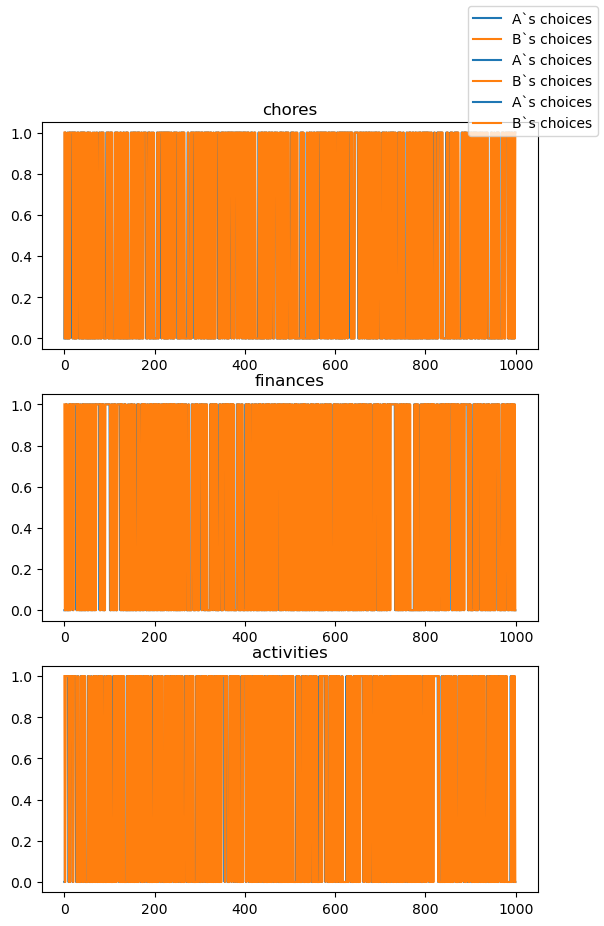

In [61]:
choices = game(random,titfortat,N=1000)
fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i], label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()

In [86]:
subgame_payoffs = np.array([[
    [[0, 0],        [A[i], -B[i]]],
    [[-A[i], B[i]], [1.5, 1.5]]]
    for i in range(3)])


def mean_payoffs(strategy_A, strategy_B, N=10000):
    choices = game(strategy_A, strategy_B, N)
    ret = np.zeros(2)
    for i in range(3):  # subgame
        for j in range(len(choices[0])):  # iteration
            ret += subgame_payoffs[i, choices[i, j, 0], choices[i, j, 1]]
    return np.round(ret/N, 2)

In [87]:
N = 10000

payoffs = []
for i in range(len(strategies)):
    payoffs.append([])
    for j in range(len(strategies)):
        payoffs[-1].append(mean_payoffs(strategies[i], strategies[j], N = N))

In [89]:
labels = [x.__name__ for x in strategies]
df = pd.DataFrame(payoffs, index=labels, columns=labels)
df
# print(df.to_latex())

,insist,compromise,titfortat,grim,gradual_forgiving,random
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0, -0.0]","[0.0, -0.0]","[0.0, -0.0]","[3.03, -3.01]"
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.78, 5.25]"
titfortat,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.12, 1.12]"
grim,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[3.01, -3.01]"
gradual_forgiving,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.89, -2.74]"
random,"[-3.0, 2.99]","[5.26, -0.8]","[1.14, 1.14]","[-2.99, 3.0]","[-2.73, 2.88]","[1.18, 1.08]"


In [80]:
def stochastic(x, p):
    if x[1] == [] or x[0] == []:
        return [1,1,1]
    p = np.array(p)
    prob = p[2 * x[0][-1] + x[1][-1]]

    return [gen.choice(a=2, p = [1 - prob[i], prob[i]]) for i in range(3)]

In [ ]:
p = [0,1,0,1] # p_dd, p_dc, p_cd, p_cc
stoch = lambda x:stochastic(x,p)

In [133]:
M = 50 # number of strategies
N = 100 # number of rounds each game
Q = 100 # number of iterations
pruned = 3
evolution_rate = 0.1

score_iter = []
p = gen.uniform(size = [M,4])
p[0] = [0,1,0,1]
for k in range(Q):
    scores = np.zeros(M)
    for i in range(M):
        sA = lambda x: stochastic(x,p[i])
        for j in range(M):
            sB = lambda x: stochastic(x,p[j])
            payoff = mean_payoffs(sA, sB, N = N)
            scores[i] += payoff[0]
            scores[j] += payoff[1]
    score_iter.append(scores / M / 2)
    inds = np.argsort(scores)
    p = p[inds]
    p[-pruned:] = p[:pruned] + gen.normal(scale = evolution_rate)
    p = np.maximum(np.minimum(p,1),0)

print(score_iter[-1])

[4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5
 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5]


In [135]:
print(p)

[[0.11821967 1.         0.11821967 1.        ]
 [0.96929043 1.         1.         0.59420757]
 [0.38505657 1.         0.38505657 1.        ]
 [0.20377135 1.         0.20377135 1.        ]
 [0.8960096  1.         0.31903579 1.        ]
 [0.91118654 1.         1.         0.53610369]
 [0.8611205  1.         1.         0.48603764]
 [0.19990185 1.         0.19990185 1.        ]
 [0.89920514 1.         1.         0.52412229]
 [0.96297168 1.         1.         0.58788882]
 [0.04674941 1.         0.04674941 1.        ]
 [0.19845392 1.         0.19845392 1.        ]
 [0.30174485 1.         0.30174485 1.        ]
 [0.31400293 1.         0.31400293 1.        ]
 [0.32151501 1.         0.32151501 1.        ]
 [1.         1.         1.         0.6299318 ]
 [0.9569829  1.         1.         0.58190004]
 [0.87757611 1.         1.         0.50249326]
 [1.         1.         1.         0.62898022]
 [0.95297438 1.         1.         0.57789153]
 [0.9888274  1.         1.         0.61374455]
 [0.13155233 

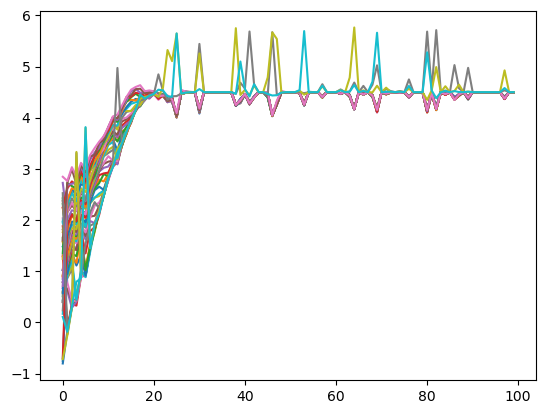

In [134]:
plt.plot(score_iter)
plt.show()